In [4]:
! pip install hazm

     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 233 kB 49.2 MB/s 
     |████████████████████████████████| 1.4 MB 47.9 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394488 sha256=ce5f5ba92345094d4027806642c42fd7d1c258d64263bf3fcbad4804ea67598f
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154980 sha256=2ca8fc49f99065874f4297c77319924a9b890e7864a0718a5eb0cde20b26f81f
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [5]:
import numpy as np
import pandas as pd
import os, json


## Find the average score of each word
### You don't need to run this. I have calculated them before.

In [ ]:
path_to_json = '/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files)

In [ ]:
all_dicts = []
sum_dict = {}
occurance = {}

import regex as re
for file in json_files:
  f = open(path_to_json+file) 
  data = json.load(f)
  data.pop('_id')
  data.pop('name')
  data.pop('time')
  data.pop('last_answer')
  all_dicts.append(data)

  for k in set(sum_dict)|set(data):
    new_sum = int(sum_dict.get(k, 0)) + int(data.get(k, 0))
    sum_dict.update({k: new_sum})

for k in sum_dict:
  occ = sum([1 for d in all_dicts if k in d])
  occurance.update({k:occ})

avg_dict = {k: int(sum_dict.get(k, 0))/(occurance.get(k,-1)) for k in set(sum_dict)}
print(sum_dict)
print(avg_dict)

In [8]:
# You can save the average score of the words once
# I have saved them before. Therefore I am commenting this part

# with open('/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/word_avg_anger_and_happiness.csv', 'w') as f:
#     for key in avg_dict.keys():
#         f.write("%s,%s\n"%(key,avg_dict[key]))

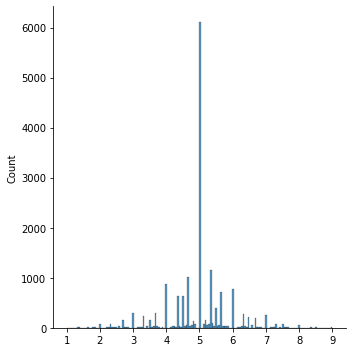

In [10]:
# See the distribution of words
import seaborn as sns
sns.displot(values)

## Load the average score of each word from the saved data

In [ ]:
avg_score_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/word_avg_anger_and_happiness.csv',names=['word','score'])

In [ ]:
avg_dict = dict(zip(avg_score_df['word'], avg_score_df['score']))
del avg_score_df
avg_dict

## Get the words and their indices 

In [ ]:
words_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/words.txt', names = ['word'])
words_df.index = np.arange(1, len(words_df)+1)
words_df

In [28]:
happiness_score = {}
anger_score = {}

for i in range(1,len(words_df['word'])+1):
  h_score = avg_dict.get(str('h'+str(i)), 5)
  a_score = avg_dict.get(str('a'+str(i)), 5)
  word = words_df['word'][i]
  happiness_score.update({word:h_score})
  anger_score.update({word:a_score})

words_df.shape

(8375, 1)

In [ ]:
# avg_dict.get('h'+str(1))

## Get some tweets and clean them up and calculate the average

In [17]:
# You can name this variable whatever you wish to make distinction with
# mine was based on monthYear
month = 'dec2021'

In [ ]:
# Load the dataset of your tweets
# I loaded the dataset of the the month I was willing to analize
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/{}tweets.csv'.format(month))
df.head()

In [ ]:
# Removing the redundant columns to save sum RAM
df.drop(['conversation_id','language','retweets_count', 'mentions',  'likes_count','possibly_sensitive','in_reply_to_user_id', 'source','user_id', 'in_reply_to_status_id', 'replies_count','quoted_status_id','hashtags','cashtags', 'urls'], axis = 1, inplace=True)
df.rename(columns={'created_at': 'Datetime','tweet': 'Text'},inplace=True)

df

In [20]:
# Since my tweets are in Persian, I use hazm instead of nltk.
import hazm as hz
import regex as re

In [114]:
# delta_h will identify the range of your neutral words
delta_h = 2

In [115]:
# These are basically the happiness_score dictionary and anger_score dictionary.
# The difference is that we omit the words within with the score 5-delta_h and
# 5+delta_h. Therefore are results will be more precise. My neutral score is 5.
delta_h_score_dict = dict(filter(lambda elem: abs(elem[1]-5) >= delta_h, happiness_score.items()))
print(len(delta_h_score_dict))
delta_a_score_dict = dict(filter(lambda elem: abs(elem[1]-5) >= delta_h, anger_score.items()))
print(len(delta_a_score_dict))

960
421


In [116]:
normalizer = hz.Normalizer()
# df['tokens'] = np.nan
# df['tokens'] = df.tokens.astype(object)
df['happiness_score'] = np.nan
df['anger_score'] = np.nan

all_h_scores = []
all_a_scores = [] 
size = df.shape[0]
for i in range(0,100): print('|',end='')
print('')

for i in range(df.shape[0]):

  # Remove links
  link_pttrn = r"http\S+"
  df.at[i,'Text'] = re.sub(link_pttrn, "", df.at[i,'Text'])

  # Remove mentions
  mention_pttrn = r'@\w+'
  df.at[i,'Text'] = re.sub(mention_pttrn, '', df.at[i,'Text'])

  # Normalize
  df.at[i,'Text'] = normalizer.normalize(str(df.at[i,'Text']))

  # Tokenize
  tokens = hz.word_tokenize(str(df.iloc[i]['Text']))
  # df.at[i,'tokens'] = tokens

  # Get the avg score of each token & calculate the avg score of the whole text
  # for happiness and anger
  h_sum = 0
  h_count = 0
  a_sum = 0
  a_count = 0
  for tok in tokens:

    h_score = happiness_score.get(tok, -1)
    if h_score != -1:
      h_count += 1
      h_sum += h_score      
    
    a_score = anger_score.get(tok, -1)
    if a_score != -1:
      a_count += 1
      a_sum += a_score

  if h_count != 0:
    df.at[i, 'happiness_score'] = h_sum/h_count
    all_h_scores.append(h_sum/h_count)

  if a_count != 0:
    df.at[i, 'anger_score'] = a_sum/a_count
    all_a_scores.append(a_sum/a_count)

  if not (i%int(size/100)):
    print('|',end='')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [ ]:
df.head()

In [117]:
print('mean of the happiness score of the remaining words: ', 
      np.mean(all_h_scores))
print('mean of the     anger score of the remaining words: ', 
      np.mean(all_a_scores))

mean of the happiness score of the remaining words:  5.2434377387617825
mean of the     anger score of the remaining words:  4.118063634795773


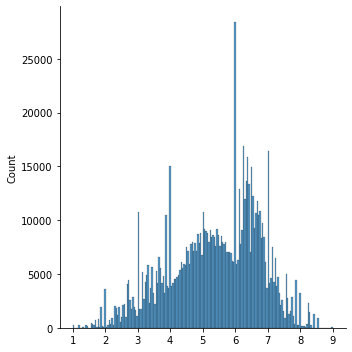

In [102]:
import seaborn as sns
sns.displot(all_h_scores)

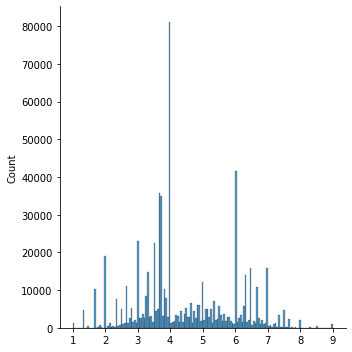

In [103]:
sns.displot(all_a_scores)

In [ ]:
# You can save the processed df for later use. I didn't do it.
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/processed_tweets_ahvalpors_{}_h{}.csv'.format(month,delta_h))

## Now filter the df by the date and get the avg of tweets for each day

In [ ]:
# If you saved the processed df, you can load it here
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/processed_tweets_ahvalpors_{}_h{}.csv'.format(month,delta_h))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# To remove some noise from my data.
# df= df[ df[ 'Text' ].str.contains('#Release_TLPAmeerSHR')==False ]
# df= df[ df[ 'Text' ].str.contains('the good')==False ]

In [ ]:
import datetime
dates = []
# Specify the dates you want to analize
start = pd.to_datetime('12-01-2021')
end = pd.to_datetime('01-01-2022')
print((end-start).days)
h_score = []
a_score = []
for j in pd.date_range(start, periods=(end - start).days):
  print(j.day, end=', ')
  start_date = j
  end_date = start_date + datetime.timedelta(days=1)
  df['Datetime'] = pd.to_datetime(df['Datetime']).dt.date
  after_start_date = df["Datetime"] >= start_date
  before_end_date = df["Datetime"] <= end_date
  between_two_dates = after_start_date & before_end_date
  filtered_dates = df.loc[between_two_dates]
  dates.append(start_date)
  h_score.append(filtered_dates["happiness_score"].mean())
  a_score.append(filtered_dates['anger_score'].mean())
  # print(filtered_dates)

In [119]:
results = pd.DataFrame(data=[dates,h_score, a_score])
results = results.transpose()
results.rename({0:'Date',1:'h_score',2 :'a_score'},axis=1,inplace=True)
# results

In [120]:
# Saving the scores of happiness and anger for this certain period
results.to_csv('/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/score_of_{}_ahvalpors_h{}.csv'.format(month,delta_h))

## Plot the results

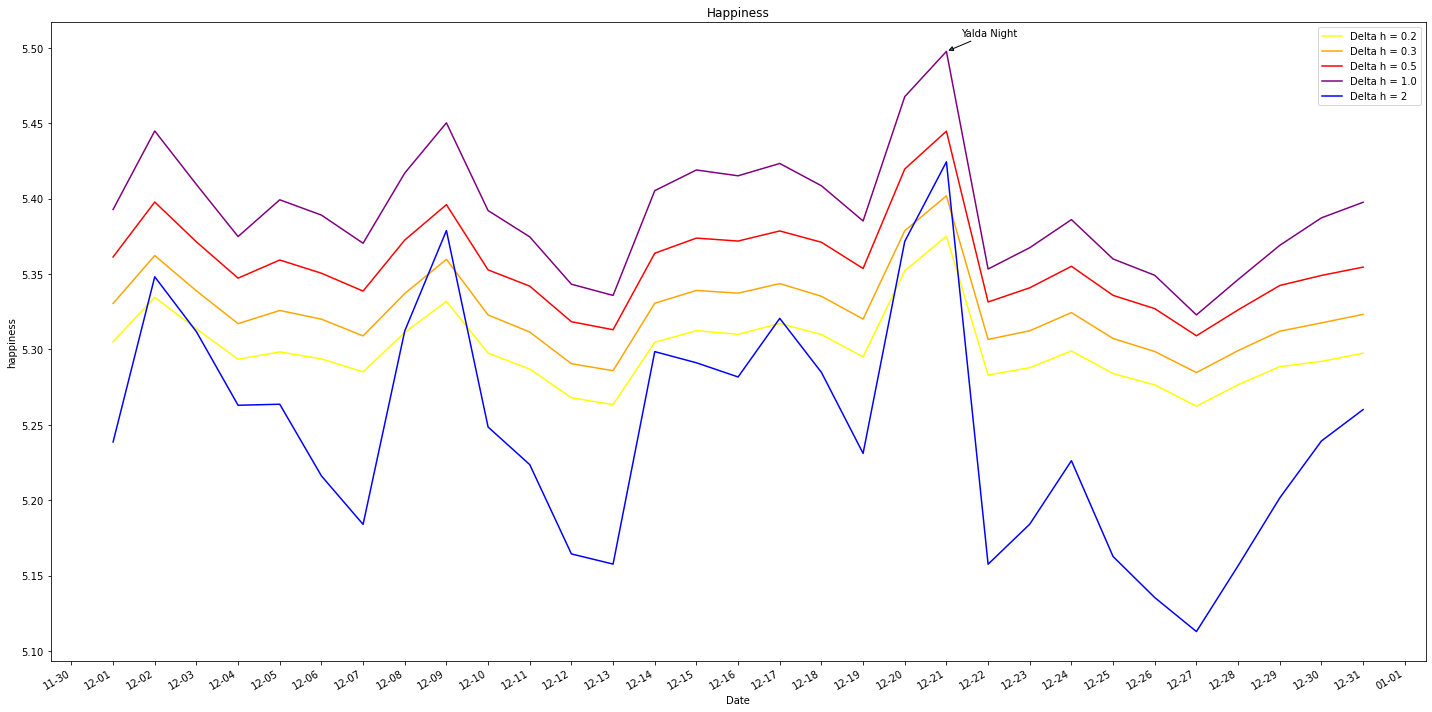

In [124]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [20.00, 10]
plt.rcParams["figure.autolayout"] = True

# Create figure and plot space
fig, ax = plt.subplots()

# Add x-axis and y-axis
# ax.plot(dates,h_score_020,color='yellow',label='Delta h = 0.2')
# ax.plot(dates,h_score_030,color='orange',label='Delta h = 0.3')
# ax.plot(dates,h_score_050,color='red',label='Delta h = 0.5')
# ax.plot(dates,h_score_100,color='purple',label='Delta h = 1.0')
ax.plot(dates,h_score,color='blue',label='Delta h = {}'.format(delta_h))


# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="happiness",
       title="Happiness")

# plt.ylim(4.8, 5.35)

# Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)


# To annotate some important events on my plot
## Dec
ax.annotate('Yalda Night', (mdates.date2num(dates[20]), h_score_100[20]), xytext=(15, 15),
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
## Aug
# ax.annotate('Fall of Herat', (mdates.date2num(dates[11]), h_score[11]), xytext=(15, 15),
#             textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

# ax.annotate('Taliban takes over Kabul', (mdates.date2num(dates[14]), h_score[14]), xytext=(15, 15),
#             textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()
plt.gcf().autofmt_xdate()

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/{}_happiness_h050,030,020,100,{}.png'.format(month,delta_h))

plt.show()

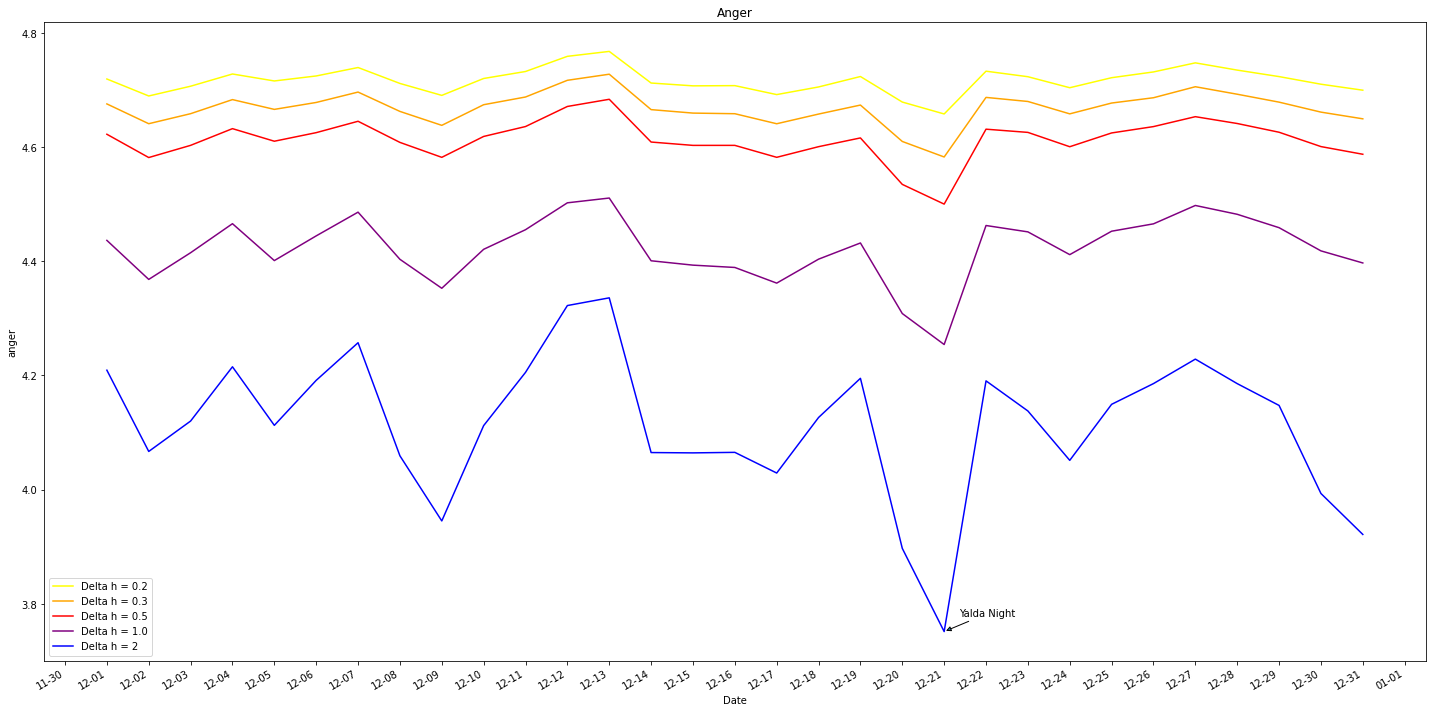

In [122]:
plt.rcParams["figure.figsize"] = [20.00, 10]
plt.rcParams["figure.autolayout"] = True

plt.rcParams["figure.figsize"] = [20.00, 10]
plt.rcParams["figure.autolayout"] = True

# Create figure and plot space
fig, ax = plt.subplots()

# Add x-axis and y-axis
# ax.plot(dates,a_score_020,color='yellow',label='Delta h = 0.2')
# ax.plot(dates,a_score_030,color='orange',label='Delta h = 0.3')
# ax.plot(dates,a_score_050,color='red',label='Delta h = 0.5')
# ax.plot(dates,a_score_100,color='purple',label='Delta h = 1.0')
ax.plot(dates,a_score,color='blue',label='Delta h = {}'.format(delta_h))

# Set title and labels for axes
ax.set(xlabel="Date",ylabel="anger",title="Anger")

# plt.ylim(4.8, 5.35)

# Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

## Dec
ax.annotate('Yalda Night', (mdates.date2num(dates[20]), a_score[20]), xytext=(15, 15),
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
## Aug
# ax.annotate('Fall of Herat', (mdates.date2num(dates[11]), a_score[11]), xytext=(15, 15),
#             textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
# ax.annotate('Taliban takes over Kabul', (mdates.date2num(dates[14]), a_score[14]), xytext=(15, 15),
#             textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()
plt.gcf().autofmt_xdate()

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Ahvalpors (1)/{}_anger_h050,030,020,100,{}.png'.format(month,delta_h))

plt.show()

In [ ]:
# Browsing the results manually
df.loc[df['Datetime']==pd.to_datetime('12-13-2021')].sort_values(['anger_score'], ascending=False).iloc[50:100]

In [ ]:
(df[df['Text'].str.contains('the good')==False ].sort_values(['happiness_score'], ascending=False)).loc[df['Datetime']==pd.to_datetime('08-07-2021')].iloc[0:50]